## Introduction

This time we're going to work with a tiny dataset of sick leave frequency by age and sex. The data was collected over the year. 

We'll try to answer these questions:
<ol>
<li>Do men always get sick more often than women or we have got that difference by random chance?</li>
<li> And the same question about people who are over and under 35 y.o.</li>
</ol>

And one thing to consider: employees may take no more than 2 days as sick days for their own needs. So, they may not be sick at all.
Under this condition let us open the veil.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Looking at the data

At the first step, it is essential to look at the data structure and the data itself.

Hopefully there is no missing data, although there are only 237 rows.<br>
Nevertheless, we can still draw some sort of conclusion from our import.

In [2]:
df = pd.DataFrame(pd.read_csv('./data/sick_leave.csv'))
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Q. of sick days  237 non-null    int64 
 1   Age              237 non-null    int64 
 2   Sex              237 non-null    object
dtypes: int64(2), object(1)
memory usage: 5.7+ KB


,Q. of sick days,Age,Sex
0,5,39,F
1,4,54,M
2,4,26,M
3,5,42,M
4,4,29,M


Now let us draw a simple histogram to see the actual difference in number of sick leaves by groups.

In [3]:
def draw_simple_hist(data_as_list, colors_as_list, labels_as_list, title):
    
    barlist=plt.bar(range(len(data_as_list)), data_as_list, alpha=0.5, color=colors_as_list)

    for rect in barlist:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')
    axes = plt.gca()
    axes.set_ylim([0,1.2*max(data_as_list)])
    plt.xticks(range(len(data_as_list)),labels_as_list)
    plt.title(title)

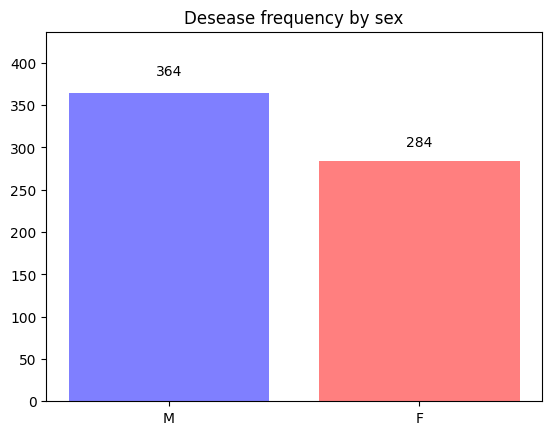

In [4]:
m = sum(df.loc[(df.iloc[:,2]=='M') & (df.iloc[:,0]>2),df.columns[0]])
w = sum(df.loc[(df.iloc[:,2]=='F') & (df.iloc[:,0]>2),df.columns[0]])
title = 'Desease frequency by sex'

draw_simple_hist([m,w],['b','r'],['M','F'],title)
plt.show()

As can be clearly seen, men get sick more often then women. In this case by <b>~1.3 times</b>

And here the first question arises: do men always get sick more often than women or we have got that difference by random chance?<br>
To answer this question we may use one good method:
1. Consider that there is no sick leave in desease frequency between men group and women group.
2. Concatenate the values from men group and women group.
3. After concatenation shuffle it to simulate another possible state for testing our hypothesis that data in men and women groups identically distributed.
4. Then relabel shuffled data to form new men and women groups

And that we will call a permutation sample.

In [5]:
def permutation_sample(data_1, data_2):
    data = np.concatenate((data_1,data_2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data_1)]
    perm_sample_2 = permuted_data[len(data_1):]
    
    return perm_sample_1, perm_sample_2

However, a single permutation would only provide us one possible case of many.

Thus, we better make a lot of them to understand how many times the difference we are looking for appears.

In [6]:
def make_perm_reps(data_1, data_2, func, size=1):

    perm_replicates = np.empty(size)

    for i in range(size):

        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

And as you have noticed in the code above there is one reference in <span style="color:blue">make_perm_reps</span> - <b>func</b>.<br>This <b>func</b> is the mesurement we choose to answer the question of how reasonable the observed data is assuming the hypothesis of identical distribution is true.

In this case we may use the measurement as difference in sums of sick leaves between two groups

In [7]:
def diff_in_times(data_1, data_2):
    return sum(data_1)/sum(data_2)

By this moment we have already created functions for simulating other cases with concrete measurement to compare with.

Therefore, now we have the ability to make tests to see the comparison between observed data and the predictions based on our hypothesis.

And via these tests make conclusions.

With the assumption of identically distributed data we may suppose that there is no difference between men and women. So the difference in times should be equal to 1.

From the current loaded file we have already got 1.3 times difference. <br>
Next we have to find out is this difference outlier or not  by making **10 000 permutations** to be sure we have covered most cases.

For this one interesting test statistic could be implemented. The p-value.
With the p-value we can calculate the probability of obtaining difference from permutations that is at least as extreme as what we observed, with consideration that our data is identically distributed.

In [8]:
def calc_p_value(data_1, data_2):
    initial_diff_times = diff_in_times(data_1, data_2)

    perm_replicates = make_perm_reps(data_1, data_2, diff_in_times, size=10000)

    p_value = sum(perm_replicates>=initial_diff_times) / len(perm_replicates)
    
    return initial_diff_times, perm_replicates, p_value

In [9]:
def draw_perm_distr(perm_replicates):
    plt.hist(perm_replicates, color='b', alpha=0.5, bins=100)
    plt.title("Permutations' measurements")
    plt.xlabel('value')
    plt.ylabel('frequency')

In [10]:
def draw_p_value(perm_replicates, initial_diff_times, p_value):
    perms = plt.hist(perm_replicates[perm_replicates<initial_diff_times], color='b', alpha=0.5, bins=100, label='permutations')
    init = plt.plot([initial_diff_times]*2,[0,500], color='r', alpha=1, linewidth=3, label='observed difference')
    pv = plt.hist(perm_replicates[perm_replicates>=initial_diff_times], color='g', alpha=0.5, bins=100, label='p-value')
    plt.title('The share of values at least as extreme as observed, p-value')
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc=1)
    plt.xlabel('value')
    plt.ylabel('frequency')

In [11]:
men = df.loc[(df.iloc[:,2]=='M') & (df.iloc[:,0]>2),df.columns[0]]
women = df.loc[(df.iloc[:,2]=='F') & (df.iloc[:,0]>2),df.columns[0]]


initial_diff_times, perm_replicates, p_value = calc_p_value(men, women)

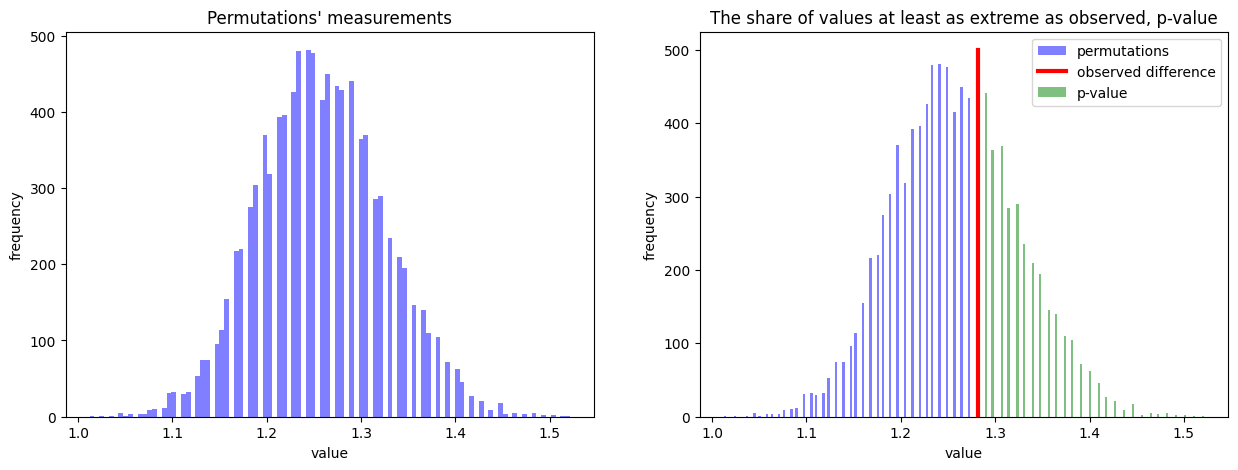

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(121)
draw_perm_distr(perm_replicates)
plt.subplot(122)
draw_p_value(perm_replicates, initial_diff_times, p_value)
plt.show()

In [13]:
print('And the p-value equals... %1.3f' %p_value)

And the p-value equals... 0.360


Thus we can state that <b>~36% of the time</b> we would get the difference more or equal to the value we have observed.

Therefore, one conclusion may be drawn from here - *men get sick more often than women minimum 36% of the time*.

Thanks to us, the answer to the second question "Do elders always get sick more often than babies or we have got that difference by random chance?" is not that far as it was in the beginning.

So all we need is to extract new filtered data and run it through the functions

*Elders - people over 35 y.o.*<br>
*Babies - people under 35 y.o.*

In [14]:
over_35 = df.loc[(df.iloc[:,1]>35) & (df.iloc[:,0]>2),df.columns[0]]
under_35 = df.loc[(df.iloc[:,1]<=35) & (df.iloc[:,0]>2),df.columns[0]]

initial_diff_times, perm_replicates, p_value = calc_p_value(over_35, under_35)

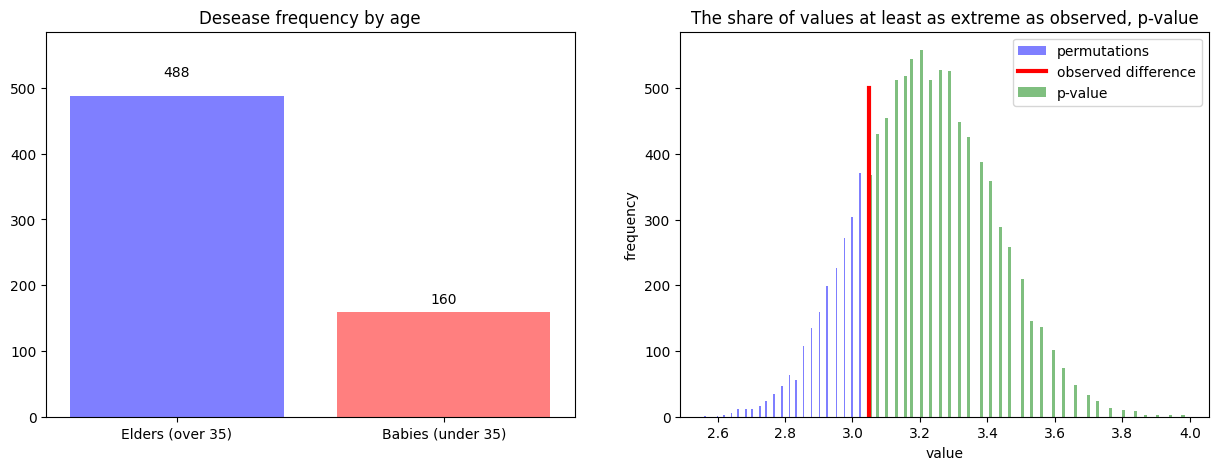

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(121)
title = 'Desease frequency by age'
draw_simple_hist([sum(over_35),sum(under_35)],['b','r'],['Elders (over 35)','Babies (under 35)'],title)
plt.subplot(122)
draw_p_value(perm_replicates, initial_diff_times, p_value)
plt.show()

In [16]:
print('The p-value equals %1.3f' %p_value)

The p-value equals 0.794


Wow, <b>~80% of the time</b>! That's interesting.

Thus we got that elders get sick more often than babies in almost all cases with condition that our data is identically distributed.